In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from scipy import stats

In [321]:
##load the data - the data was created in qupath by exporting the annotations measuremetns

os.getcwd() 
at_p42 = pd.read_csv('../data/Animal_tags_w4.csv',sep=';')
at_p86 = pd.read_csv('../data/animal_tags_w8.csv',sep=';')


pv_p42_df = pd.read_csv('../data/cell_counts_raw_PV_w4.csv')
pv_p86_df = pd.read_csv('../data/cell_counts_raw_PV_w8.csv')

dapi_p42_df = pd.read_csv('../data/cell_counts_raw_DAPI_w4.csv')
dapi_p86_df = pd.read_csv('../data/cell_counts_raw_DAPI_w8.csv')

neun_data_df = pd.read_csv('../data/NeuN data.csv')


keys = ['pv_p42_df','pv_p86_df','dapi_p42_df','dapi_p86_df']

dfs = [pv_p42_df,pv_p86_df,dapi_p42_df,dapi_p86_df]

df_dict = dict(zip(keys,dfs))



for i in df_dict:
    df_dict[i]['timepoint'] = i.split('_')[1]
    df_dict[i]['animal_tag'] = df_dict[i].Image.str.split('_',n = 2,expand=True)[1]
    if 'dapi' in i:
        df_dict[i]['Name'] = 'cortex_roi'
        df_dict[i] = df_dict[i][df_dict[i]['Num Detections'] != 0].copy()
        df_dict[i]['n_dapi'] = df_dict[i]['Num Detections']
        df_dict[i] = df_dict[i][['Name','n_dapi','Area µm^2','Perimeter µm','animal_tag']].copy()
    else:

        cort = df_dict[i][df_dict[i]['Name']=='cortex_roi'].copy()
        crb = df_dict[i][df_dict[i]['Name']=='cerebellum_roi'].copy()
        cort['Num Positive'] = cort['Num Detections']
        df_dict[i] = pd.concat([cort,crb])

        df_dict[i]['n_pv'] = df_dict[i]['Num Positive']


        df_dict[i] = df_dict[i][['Name','n_pv','Area µm^2','Perimeter µm','animal_tag']].copy()

    df_dict[i].rename(columns={"Area µm^2": "area_um2", "Perimeter µm": "perimeter_um",'Name' : 'name'},inplace=True)

    df_dict[i]['area_mm2'] = df_dict[i]['area_um2']* 10e-6








#time points: P42 (w4), p86 (w8) - wrong filenames we roll with that

In [322]:
##timepoint 1

pv_cort_p42 = df_dict['pv_p42_df'][df_dict['pv_p42_df']['name']=='cortex_roi'].copy() #split the the cortex and the cerebellum ROI counts
cer_p42 = df_dict['pv_p42_df'][df_dict['pv_p42_df']['name']=='cerebellum_roi'].copy()

cort_p42 = pv_cort_p42.merge(df_dict['dapi_p42_df'],on = 'animal_tag',how='outer') ##merge the dapi with the PV for the cortical count


##timepoint 2
pv_cort_p86 = df_dict['pv_p86_df'][df_dict['pv_p86_df']['name']=='cortex_roi'].copy() #split the the cortex and the cerebellum ROI counts
cer_p86 = df_dict['pv_p86_df'][df_dict['pv_p86_df']['name']=='cerebellum_roi'].copy()

cort_p86 = pv_cort_p86.merge(df_dict['dapi_p86_df'],on = 'animal_tag',how='outer') ##merge the dapi with the PV for the cortical count

for frame in [cort_p86,cort_p86,cer_p42,cer_p86]: #drop columns containing duplicates
    frame = frame.T.drop_duplicates().T


##process the cortical sampels    

cort_b = [cort_p42,cort_p86] ## make some lists to help with the loop
genotypes = [at_p42,at_p86]
time_points = ['P42','P84']
for idx, frame in enumerate(cort_b): ## loop over timepoints
    frame['dapi_density'] = frame['n_dapi']/frame['area_mm2_y'] ##dapi denisty column
    frame['pv_density'] = frame['n_pv']/frame['area_mm2_x'] ##pv denisty column
    frame['pv/dapi'] = frame['pv_density']/frame['dapi_density'] ##PV over dapi column
    frame['KO'] = frame.animal_tag.astype('int').isin(genotypes[idx][time_points[idx] + '_KO'].values) ##add genotype - first find in the value list
    frame['Genotype'] = frame['KO'].map({True: 'KO', False: 'WT'}) ##add genotype - make new column based off the column made earlier
    frame['Timepoint'] = time_points[idx]


# Combine the dataframes
both_timepoints_cort = pd.concat(cort_b)

# Reset index if necessary
both_timepoints_cort.reset_index(drop=True, inplace=True)


# rename colums to make more sense later

both_timepoints_cort.rename(columns=lambda x: x.replace('_x', '_pv').replace('_y', '_dapi'), inplace=True)
both_timepoints_cort.drop(columns = ['KO'],inplace=True)


##add the nen data from the previous work

neun_data_df.rename(columns={"Mouse":'animal_tag','Density':'nen_density'},inplace=True)
neun_data_df_rel = neun_data_df[(neun_data_df['Location']=='Cortex') & ((neun_data_df['Day'] == 42) |(neun_data_df['Day'] == 84))].copy()
neun_data_df_rel = neun_data_df_rel[['animal_tag','nen_density','Percentage','Day']]


both_timepoints_cort['animal_tag'] = both_timepoints_cort['animal_tag'].astype(int)


both_timepoints_cort = both_timepoints_cort.merge(neun_data_df_rel,on = 'animal_tag',how = 'outer')
#both_timepoints_cort  = both_timepoints_cort[~both_timepoints_cort['Timepoint'].isnull()].copy()

#divide the earlier result - add a new column

both_timepoints_cort['pv/nen'] = both_timepoints_cort['pv_density']/both_timepoints_cort['nen_density']


both_timepoints_cort.to_csv('../data/cortex_cell_counts_PV_dapi.csv',index=False)



##cerebellum cell count
##here we use the perimeter to fiugre out the lenght the ROI - we then divide it by the cell counts to get the amount go cells per unit lenght of the moleciualr/granular cell layer boundary


cer_b = [cer_p42,cer_p86] ## make some lists to help with the loop
genotypes = [at_p42,at_p86]
time_points = ['P42','P84']
p = 82.38 ##perimeter of the brush tool in qupath

for idx, frame in enumerate(cer_b):
    frame['lenght_um'] = 0.5 * (frame['perimeter_um'] - p + p/(np.pi)) #roi legnth (has a sausage like shape)
    frame['lenght_mm'] = frame['lenght_um'] * 10e-3

    frame['pv_per_mm'] = frame['n_pv']/frame['lenght_mm'] ##pv per length column

    frame['KO'] = frame.animal_tag.astype('int').isin(genotypes[idx][time_points[idx] + '_KO'].values) ##add genotype - first find in the value list
    frame['Genotype'] = frame['KO'].map({True: 'KO', False: 'WT'}) ##add genotype - make new column based off the column made earlier
    frame['Timepoint'] = time_points[idx]



# Combine the dataframes
both_timepoints_cer = pd.concat(cer_b)

# Reset index if necessary
both_timepoints_cer.reset_index(drop=True, inplace=True)


# rename colums to make more sense later

both_timepoints_cer.rename(columns=lambda x: x.replace('_x', '_pv').replace('_y', '_dapi'), inplace=True)
both_timepoints_cer.drop(columns = ['KO'],inplace=True)

both_timepoints_cer.to_csv('../data/cerbellum_cell_counts_PV.csv',index=False)



##next steop: drive the lenght of the cer_roi, add genotype

In [325]:
neun_data_df

,Slide_No,animal_tag,Location,Genotype,Day,nen_density,Percentage
0,5429_1,480,Cortex,WT,7,32.575071,31.791185
1,5430_1,472,Cortex,KO,7,35.103342,29.017079
2,5431_1,431,Cortex,KO,7,33.316361,29.284064
3,5432_2,728,Cortex,WT,42,22.590833,26.861193
4,5433_2,488,Cortex,KO,7,36.267405,27.395205
...,...,...,...,...,...,...,...
189,5495_1,593,Cere_M,KO,42,6.306201,3.334116
190,5497_2,628,Cere_M,KO,42,4.812188,2.351683
191,5426_1,277,Cere_M,WT,84,8.707983,1.183227
192,5427_2,254,Cere_M,KO,84,3.791745,1.243863


In [161]:
df_dict[i][df_dict[i]['Name']=='cortex_roi'].loc[:,'Num Positive'] = df_dict[i][df_dict[i]['Name']=='cortex_roi'].loc[:,'Num Detections']
df_dict[i][df_dict[i]['Name']=='cortex_roi'].copy()

cort = df_dict[i][df_dict[i]['Name']=='cortex_roi'].copy()
crb = df_dict[i][df_dict[i]['Name']=='cerebellum_roi'].copy()
cort['Num Positive'] = cort['Num Detections']
pd.concat([cort,crb])

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Num Detections,...,Num Positive,Num Positive: Ignore*,Positive %,Ignore*: Positive %,+ Ignore*: Positive %,Num Positive per mm^2,Area µm^2,Perimeter µm,timepoint,animal_tag
0,0_521_009_C2.tif,a5289e57-a0c1-4446-b4d6-05918fb5aac4,Annotation,cortex_roi,NaN,Root object (Image),Geometry,848.03,2178.10,50,...,50.0,0.0,NaN,NaN,NaN,0.00,270631.4,3649.4,p42,521
2,1_703_s10_C2.tif,f044a380-7cd3-46be-8e61-27ab55a5d720,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1676.70,1399.50,79,...,79.0,NaN,NaN,NaN,NaN,0.00,296566.6,2257.5,p42,703
4,2_728_0010_C2.tif,1745dca7-1c25-49c8-a9c5-eb5bc07a0c07,Annotation,cortex_roi,NaN,Root object (Image),Polygon,3060.80,5025.30,85,...,85.0,NaN,100.0,NaN,NaN,341.31,249040.8,1985.8,p42,728
6,3_754_s7_C2.tif,e14cec38-4f2a-4719-a5d6-a36d17c1b800,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1379.60,1543.70,135,...,135.0,NaN,NaN,NaN,NaN,0.00,332476.3,2378.3,p42,754
8,4_659_s211_C2.tif,4d3a5a50-4888-4cb7-8d9a-74c86108dd32,Annotation,cortex_roi,NaN,Root object (Image),Geometry,1588.20,1734.50,104,...,104.0,0.0,NaN,NaN,NaN,0.00,294512.1,2242.9,p42,659
10,5_637_0009_C2.tif,4ee2227a-bb06-46eb-9706-49534809b47e,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1427.50,2109.00,59,...,59.0,NaN,NaN,NaN,NaN,0.00,318827.8,2241.5,p42,637
12,6_628_s11_C2.tif,0cfa4abf-a728-49b3-90d0-768bb3de5818,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1139.10,1493.90,110,...,110.0,NaN,100.0,NaN,NaN,477.72,230259.0,1918.7,p42,628
14,7_678_s8_C2.tif,aa499ab4-8f11-4da4-a4d2-893a4db58594,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1585.40,1250.30,110,...,110.0,NaN,100.0,NaN,NaN,563.55,195189.5,1800.8,p42,678
16,9_792_s4_C2.tif,a5174c5d-af1f-4ba6-8d6b-2f1692895cf8,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1679.70,1285.30,130,...,130.0,NaN,100.0,NaN,NaN,385.24,337455.9,2404.7,p42,792
18,10_692_s10_C2.tif,c60ee5e3-7a63-4255-96b0-fb9c9a96314e,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1337.40,2729.90,110,...,110.0,NaN,NaN,NaN,NaN,NaN,275632.7,2160.1,p42,692


In [113]:


df_pv_crx_p42 = df_dict['pv_p42_df'][df_dict['pv_p42_df']['Name'] == 'cortex_roi'].copy()
df_pv_crx_p86 = df_dict['pv_p86_df'][df_dict['pv_p86_df']['Name'] == 'cortex_roi'].copy()




    
df_dict['dapi_p86_df']

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Num Detections,Area µm^2,Perimeter µm,Length µm
0,3354_253_C1_2.tif,7a0bff4b-a8f2-44c1-9cfa-759b878e46c5,Annotation,cerebellum_roi,NaN,Root object (Image),Geometry,1423.10,6385.5,0,49567.7,3881.7,NaN
1,3354_253_C1_2.tif,c6b6c4c2-6fe6-4422-b1d0-e1b967d28ba5,Annotation,cortex_roi,NaN,Root object (Image),Polygon,979.06,2758.9,5360,576480.4,3136.7,NaN
2,3355_276_C1_2.tif,6123c59d-fb3f-4b36-badc-2a60d168f33e,Annotation,cerebellum_roi,NaN,Root object (Image),Geometry,1073.50,6253.6,0,50391.3,3951.4,NaN
3,3355_276_C1_2.tif,58c17cf1-62c0-47bf-aeb0-085aa44e5da5,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1564.50,2415.8,2695,274776.8,2202.9,NaN
4,3356_272_C1_2.tif,73b5dd37-d1e4-4cf1-b572-b2e8fb3cb5c1,Annotation,cerebellum_roi,NaN,Root object (Image),Geometry,1704.70,6345.6,0,36141.4,2876.5,NaN
5,3356_272_C1_2.tif,d9260e95-d319-4cab-9240-2cacd2fc72d4,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1864.50,2637.6,3357,399155.0,2678.0,NaN
6,3357_278_C1_2.tif,58aec9d6-e8bf-48dc-a5dd-4bc4e9a85b09,Annotation,cerebellum_roi,NaN,Root object (Image),Geometry,1558.80,6191.0,0,32693.6,2618.4,NaN
7,3357_278_C1_2.tif,08862f40-aa7d-440f-a0be-20dd50f496ec,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1922.70,2530.1,2373,243890.6,2080.1,NaN
8,3358_240_C1_2.tif,a3baf7c4-dfea-45fe-a052-8838611576a2,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1849.80,2377.8,1296,221709.7,1904.3,NaN
9,3358_240_C1_2.tif,615163e8-292d-4612-8ace-34197632f2ff,Annotation,cerebellum_roi,NaN,Root object (Image),Geometry,1621.70,5722.5,0,34091.8,2709.8,NaN


In [98]:



'''

filter_cortex_df = an_df[an_df['Num Detections'] != 0].copy()
filter_cortex_df['density'] = filter_cortex_df['Num Detections']/filter_cortex_df['Area µm^2']#add the denisty column


DAPI_cortex_df = DAPI_df[DAPI_df['Num Detections'] != 0].copy()
DAPI_cortex_df['density'] = DAPI_cortex_df['Num Detections']/DAPI_cortex_df['Area µm^2']#add the denisty column
'''

combined_df = df_dict['pv_p42_df'][df_dict['pv_p42_df']['Name'] == 'cortex_roi'].merge(df_dict['dapi_p42_df'],on = 'animal_tag')
combined_df

,Object type_x,Name_x,Classification_x,Parent_x,ROI_x,Centroid X µm_x,Centroid Y µm_x,Num Detections_x,Num Ignore* (base),Num Ignore*,...,Name_y,Classification_y,Parent_y,ROI_y,Centroid X µm_y,Centroid Y µm_y,Num Detections_y,Area µm^2_y,Perimeter µm_y,timepoint_y
0,Annotation,cortex_roi,NaN,Root object (Image),Geometry,848.03,2178.1,50,0.0,0.0,...,cortex_roi,NaN,Root object (Image),Geometry,843.44,2177.6,2422,285084.0,2422.9,p42
1,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1676.70,1399.5,79,NaN,0.0,...,cortex_roi,NaN,Root object (Image),Polygon,1676.70,1399.5,2186,296566.6,2257.5,p42
2,Annotation,cortex_roi,NaN,Root object (Image),Polygon,3060.80,5025.3,85,NaN,0.0,...,cortex_roi,NaN,Root object (Image),Polygon,3060.80,5025.3,1791,249040.8,1985.8,p42
3,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1379.60,1543.7,135,NaN,NaN,...,cortex_roi,NaN,Root object (Image),Polygon,1379.60,1543.7,3106,332476.3,2378.3,p42
4,Annotation,cortex_roi,NaN,Root object (Image),Geometry,1588.20,1734.5,104,NaN,0.0,...,cortex_roi,NaN,Root object (Image),Geometry,1588.20,1734.5,2449,294512.1,2242.9,p42
5,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1427.50,2109.0,59,NaN,0.0,...,cortex_roi,NaN,Root object (Image),Polygon,1427.50,2109.0,2440,318827.8,2241.5,p42
6,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1139.10,1493.9,110,NaN,0.0,...,cortex_roi,NaN,Root object (Image),Polygon,1139.10,1493.9,1983,230259.0,1918.7,p42
7,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1585.40,1250.3,110,NaN,NaN,...,cortex_roi,NaN,Root object (Image),Polygon,1585.40,1250.3,2048,195189.5,1800.8,p42
8,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1679.70,1285.3,130,NaN,0.0,...,cortex_roi,NaN,Root object (Image),Polygon,1679.70,1285.3,3086,337455.9,2404.7,p42
9,Annotation,cortex_roi,NaN,Root object (Image),Polygon,1292.40,1608.5,25,NaN,0.0,...,cortex_roi,NaN,Root object (Image),Polygon,1292.40,1608.5,1735,206257.5,1832.0,p42


In [147]:
mouse_id_list = []
for index, i in enumerate(filter_cortex_df['Image'].values):
    mouse_id_list.append(i.split('_')[1])

filter_cortex_df['mouse_id'] = mouse_id_list


mouse_id_list = []
for index, i in enumerate(DAPI_cortex_df['Image'].values):
    mouse_id_list.append(i.split('_')[1])

DAPI_cortex_df['mouse_id'] = mouse_id_list


In [150]:
filter_cortex_df['KO'] = filter_cortex_df['mouse_id'].astype(int).isin(WT_mut_df['P42_KO'].values) ##column is true if in the KO category
filter_cortex_df['Genotype'] = filter_cortex_df['KO'].map({True: 'KO', False: 'WT'}) ## add the genotype


DAPI_cortex_df['KO'] = DAPI_cortex_df['mouse_id'].astype(int).isin(WT_mut_df['P42_KO'].values) ##column is true if in the KO category
DAPI_cortex_df['Genotype'] = DAPI_cortex_df['KO'].map({True: 'KO', False: 'WT'}) ## add the genotype

filter_cortex_df['STAIN'] = 'PV'
DAPI_cortex_df['STAIN'] = 'DAPI'

combined_df = pd.concat([filter_cortex_df,DAPI_cortex_df])
combined_df.reset_index(inplace=True)


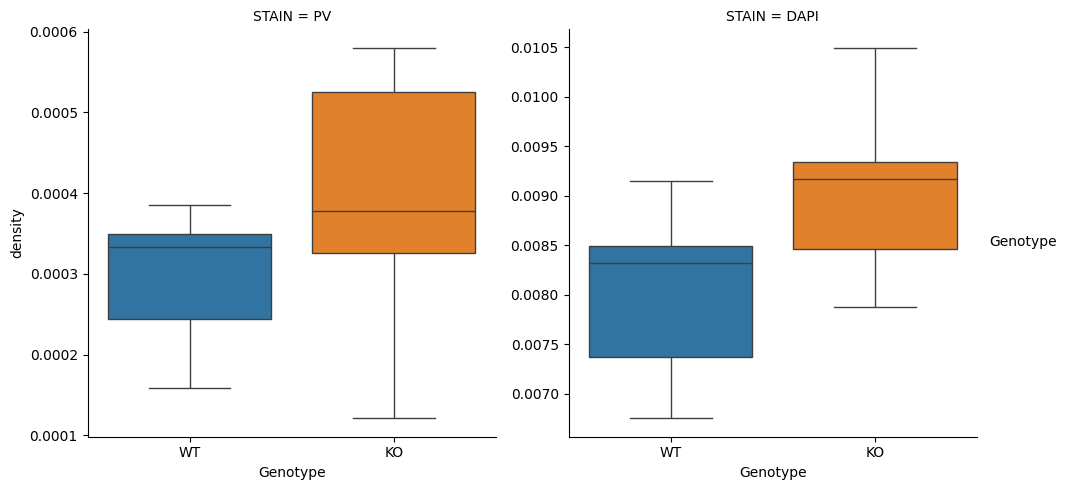

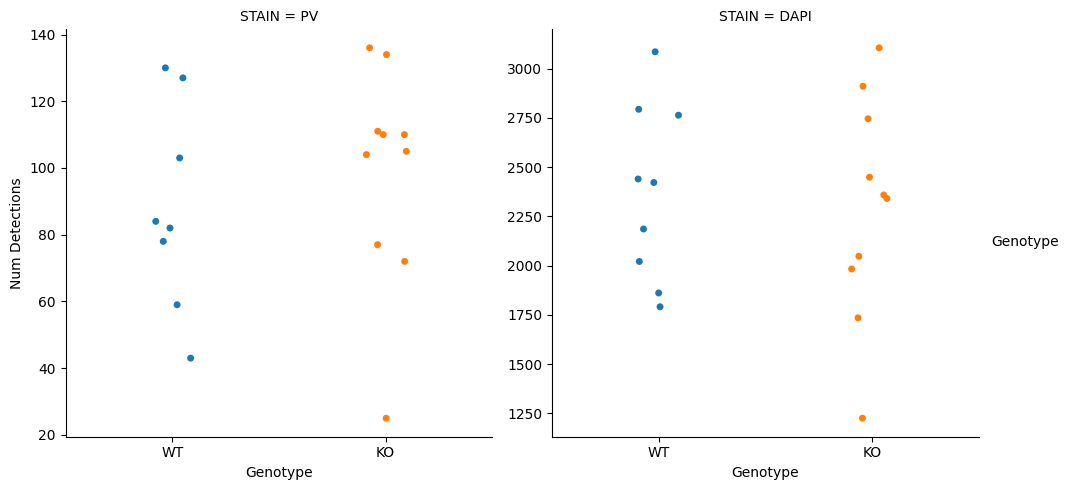

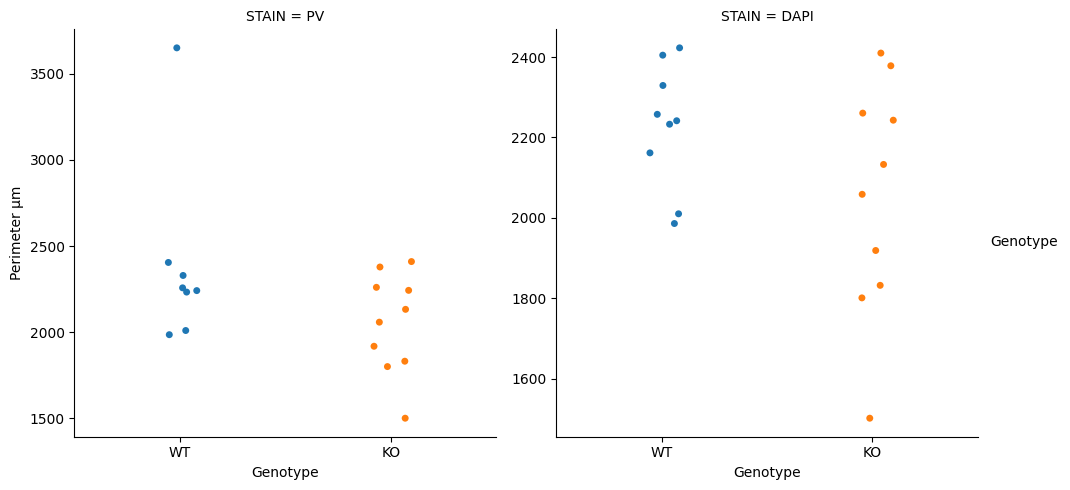

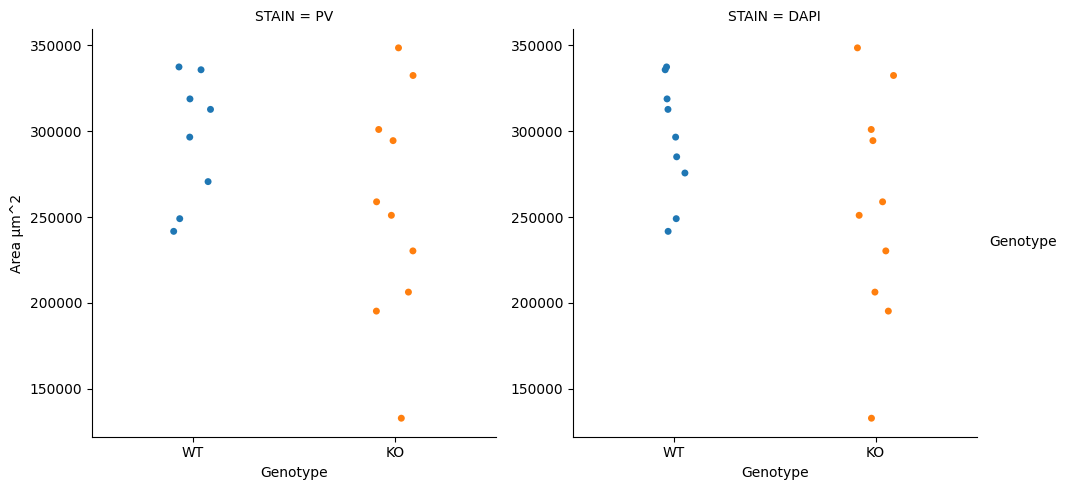

In [177]:




sns.catplot(data=combined_df,y = 'density', x = 'Genotype',hue = 'Genotype',col = 'STAIN',sharey=False, kind = 'box' )

sns.catplot(data=combined_df,y = 'Num Detections', x = 'Genotype',hue = 'Genotype' ,col = 'STAIN',sharey=False)

sns.catplot(data=combined_df,y = 'Perimeter µm', x = 'Genotype',hue = 'Genotype' ,col = 'STAIN',sharey=False)

sns.catplot(data=combined_df,y = 'Area µm^2', x = 'Genotype',hue = 'Genotype' ,col = 'STAIN',sharey=False)



A = filter_cortex_df[filter_cortex_df['KO']]['density'].values.tolist()
B = filter_cortex_df[~filter_cortex_df['KO']]['density'].values.tolist()


t_check1=stats.ttest_ind(A,B)

A = DAPI_cortex_df[DAPI_cortex_df['KO']]['density'].values.tolist()
B = DAPI_cortex_df[~DAPI_cortex_df['KO']]['density'].values.tolist()


t_check2=stats.ttest_ind(A,B)

In [179]:
combined_df

,level_0,index,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Num Detections,Area µm^2,Perimeter µm,density,mouse_id,KO,Genotype,STAIN
0,0,0,0_521_009_C2.tif,a5289e57-a0c1-4446-b4d6-05918fb5aac4,Annotation,NaN,NaN,Root object (Image),Geometry,848.03,2178.1,43,270631.4,3649.4,0.000159,521,False,WT,PV
1,1,1,1_703_s10_C2.tif,f044a380-7cd3-46be-8e61-27ab55a5d720,Annotation,NaN,NaN,Root object (Image),Polygon,1676.70,1399.5,78,296566.6,2257.5,0.000263,703,False,WT,PV
2,2,5,2_728_0010_C2.tif,1745dca7-1c25-49c8-a9c5-eb5bc07a0c07,Annotation,NaN,NaN,Root object (Image),Polygon,3060.80,5025.3,84,249040.8,1985.8,0.000337,728,False,WT,PV
3,3,6,3_754_s7_C2.tif,e14cec38-4f2a-4719-a5d6-a36d17c1b800,Annotation,NaN,NaN,Root object (Image),Polygon,1379.60,1543.7,134,332476.3,2378.3,0.000403,754,True,KO,PV
4,4,11,4_659_s211_C2.tif,4d3a5a50-4888-4cb7-8d9a-74c86108dd32,Annotation,NaN,NaN,Root object (Image),Geometry,1588.20,1734.5,104,294512.1,2242.9,0.000353,659,True,KO,PV
5,5,15,5_637_0009_C2.tif,4ee2227a-bb06-46eb-9706-49534809b47e,Annotation,NaN,NaN,Root object (Image),Polygon,1427.50,2109.0,59,318827.8,2241.5,0.000185,637,False,WT,PV
6,6,16,6_628_s11_C2.tif,0cfa4abf-a728-49b3-90d0-768bb3de5818,Annotation,NaN,NaN,Root object (Image),Polygon,1139.10,1493.9,110,230259.0,1918.7,0.000478,628,True,KO,PV
7,7,20,7_678_s8_C2.tif,aa499ab4-8f11-4da4-a4d2-893a4db58594,Annotation,NaN,NaN,Root object (Image),Polygon,1585.40,1250.3,110,195189.5,1800.8,0.000564,678,True,KO,PV
8,8,24,9_792_s4_C2.tif,a5174c5d-af1f-4ba6-8d6b-2f1692895cf8,Annotation,NaN,NaN,Root object (Image),Polygon,1679.70,1285.3,130,337455.9,2404.7,0.000385,792,False,WT,PV
9,9,31,11_630_0009_C2.tif,d0a63d1b-ede1-4b28-8d42-86bf4d9f6ca4,Annotation,NaN,NaN,Root object (Image),Polygon,1292.40,1608.5,25,206257.5,1832.0,0.000121,630,True,KO,PV


In [174]:
filter_cortex_df[filter_cortex_df['KO']]['density'].nsmallest()

filter_cortex_df[filter_cortex_df['KO']]

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Num Detections,Area µm^2,Perimeter µm,density,mouse_id,KO,Genotype,STAIN
6,3_754_s7_C2.tif,e14cec38-4f2a-4719-a5d6-a36d17c1b800,Annotation,NaN,NaN,Root object (Image),Polygon,1379.60,1543.7,134,332476.3,2378.3,0.000403,754,True,KO,PV
11,4_659_s211_C2.tif,4d3a5a50-4888-4cb7-8d9a-74c86108dd32,Annotation,NaN,NaN,Root object (Image),Geometry,1588.20,1734.5,104,294512.1,2242.9,0.000353,659,True,KO,PV
16,6_628_s11_C2.tif,0cfa4abf-a728-49b3-90d0-768bb3de5818,Annotation,NaN,NaN,Root object (Image),Polygon,1139.10,1493.9,110,230259.0,1918.7,0.000478,628,True,KO,PV
20,7_678_s8_C2.tif,aa499ab4-8f11-4da4-a4d2-893a4db58594,Annotation,NaN,NaN,Root object (Image),Polygon,1585.40,1250.3,110,195189.5,1800.8,0.000564,678,True,KO,PV
31,11_630_0009_C2.tif,d0a63d1b-ede1-4b28-8d42-86bf4d9f6ca4,Annotation,NaN,NaN,Root object (Image),Polygon,1292.40,1608.5,25,206257.5,1832.0,0.000121,630,True,KO,PV
32,12_730_s8_C2.tif,93e66ff5-8ca9-45ff-a271-c5643af21be5,Annotation,NaN,NaN,Root object (Image),Polygon,2448.70,5057.5,77,132778.1,1501.4,0.000580,730,True,KO,PV
36,13_629_s8_C2.tif,8e575adf-4567-49d1-9b7b-e48b6f9e0095,Annotation,NaN,NaN,Root object (Image),Polygon,1160.60,2258.6,111,348574.1,2409.9,0.000318,629,True,KO,PV
46,15_644_s14_C2.tif,5b9ec299-598f-4c80-a4a2-7e9f41efcad2,Annotation,NaN,NaN,Root object (Image),Polygon,763.63,1931.9,136,251002.7,2058.5,0.000542,644,True,KO,PV
51,16_729_s9_C2.tif,d3b250f1-37f1-405a-b049-c904dc1c5be8,Annotation,NaN,NaN,Root object (Image),Polygon,858.28,1259.2,105,301007.1,2260.5,0.000349,729,True,KO,PV
52,17_690_0009_C2.tif,92d77588-9811-41e0-a316-2e4052ea167b,Annotation,NaN,NaN,Root object (Image),Polygon,1064.10,1747.5,72,258866.4,2132.8,0.000278,690,True,KO,PV


In [138]:
filter_cortex_df['density'].nlargest(10)

32    0.000580
20    0.000564
46    0.000542
16    0.000478
6     0.000403
24    0.000385
42    0.000378
11    0.000353
51    0.000349
60    0.000339
Name: density, dtype: float64

In [139]:
filter_cortex_df

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Num Detections,Area µm^2,Perimeter µm,density,mouse_id,KO,Genotype
0,0_521_009_C2.tif,a5289e57-a0c1-4446-b4d6-05918fb5aac4,Annotation,NaN,NaN,Root object (Image),Geometry,848.03,2178.1,43,270631.4,3649.4,0.000159,521,False,WT
1,1_703_s10_C2.tif,f044a380-7cd3-46be-8e61-27ab55a5d720,Annotation,NaN,NaN,Root object (Image),Polygon,1676.70,1399.5,78,296566.6,2257.5,0.000263,703,False,WT
5,2_728_0010_C2.tif,1745dca7-1c25-49c8-a9c5-eb5bc07a0c07,Annotation,NaN,NaN,Root object (Image),Polygon,3060.80,5025.3,84,249040.8,1985.8,0.000337,728,False,WT
6,3_754_s7_C2.tif,e14cec38-4f2a-4719-a5d6-a36d17c1b800,Annotation,NaN,NaN,Root object (Image),Polygon,1379.60,1543.7,134,332476.3,2378.3,0.000403,754,True,KO
11,4_659_s211_C2.tif,4d3a5a50-4888-4cb7-8d9a-74c86108dd32,Annotation,NaN,NaN,Root object (Image),Geometry,1588.20,1734.5,104,294512.1,2242.9,0.000353,659,True,KO
15,5_637_0009_C2.tif,4ee2227a-bb06-46eb-9706-49534809b47e,Annotation,NaN,NaN,Root object (Image),Polygon,1427.50,2109.0,59,318827.8,2241.5,0.000185,637,False,WT
16,6_628_s11_C2.tif,0cfa4abf-a728-49b3-90d0-768bb3de5818,Annotation,NaN,NaN,Root object (Image),Polygon,1139.10,1493.9,110,230259.0,1918.7,0.000478,628,True,KO
20,7_678_s8_C2.tif,aa499ab4-8f11-4da4-a4d2-893a4db58594,Annotation,NaN,NaN,Root object (Image),Polygon,1585.40,1250.3,110,195189.5,1800.8,0.000564,678,True,KO
24,9_792_s4_C2.tif,a5174c5d-af1f-4ba6-8d6b-2f1692895cf8,Annotation,NaN,NaN,Root object (Image),Polygon,1679.70,1285.3,130,337455.9,2404.7,0.000385,792,False,WT
31,11_630_0009_C2.tif,d0a63d1b-ede1-4b28-8d42-86bf4d9f6ca4,Annotation,NaN,NaN,Root object (Image),Polygon,1292.40,1608.5,25,206257.5,1832.0,0.000121,630,True,KO


In [1]:
an_df

NameError: name 'an_df' is not defined